Loading and processing data

In [1]:
!pip install tensorflow-addons
!pip install tensorflow-io

You should consider upgrading via the 'd:\au\university\3rd semester\very deep\project repo\audioclassification\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'd:\au\university\3rd semester\very deep\project repo\audioclassification\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
# This is only needed if the project is run in Google Colab
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except:
    pass

In [11]:
# This is only needed if the project is run in Google Colab
import sys
sys.path.append('/content/drive/MyDrive')

Number of genres: 10
A label looks like the following way:
[0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
(952, 100, 100)
Shape of images: (100, 100)


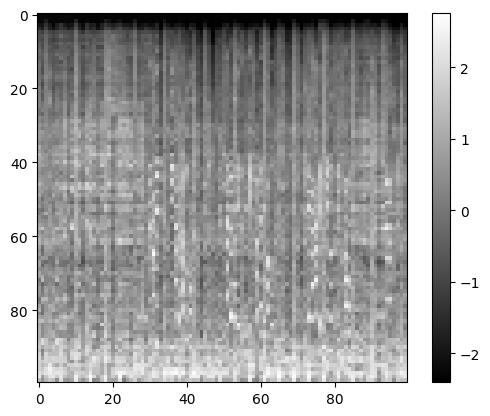

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from help import show_image_from_each_class, label_to_genre, find_genre_indices
import random
import pandas as pd
from sklearn import preprocessing
import cv2
from tqdm import tqdm
# data augmentation
import tensorflow_addons as tfa
import tensorflow_io as tfio
import tensorflow as tf
import numpy as np

# This is only needed if the project is run in Google Colab
try:
    images_original = np.load("/content/drive/MyDrive/images2.npy")
    labels = np.load("/content/drive/MyDrive/labels2.npy")
except FileNotFoundError:
    images_original = np.load("../data/processed/images2.npy")
    labels = np.load("../data/processed/labels2.npy")

genre_indices = find_genre_indices(labels)
print("Number of genres: " + str(len(genre_indices)))
print("A label:")
print(labels[0])

use_n_genres = 10
images_original = images_original[:genre_indices[use_n_genres-1]]
print(images_original.shape)
labels = labels[:genre_indices[use_n_genres-1],:use_n_genres]
input_shape = images_original.shape[1:]
print("Shape of images: " + str(input_shape))

scaler = preprocessing.StandardScaler()
images = scaler.fit_transform(images_original.reshape(-1, images_original.shape[-1])).reshape(images_original.shape)
del images_original

images = images.astype(np.double)

plt.imshow(images[60], cmap="gray")
plt.colorbar()
plt.show()


In [3]:
images.shape

(952, 100, 100)

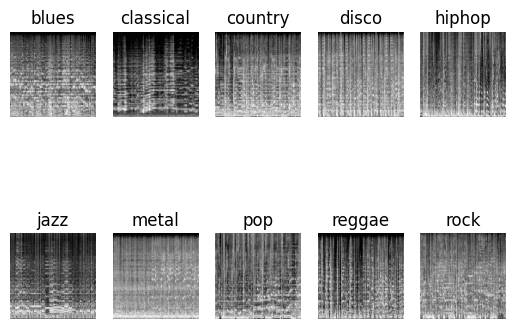

In [4]:
show_image_from_each_class(images, genre_indices, use_n_genres)

In [10]:
from sklearn.model_selection import train_test_split

# Splitting data into train and test set
x_train_simple, x_test, y_train_simple, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=1.0/3)
print("Train set length: " + str(len(x_train_simple)))
print("Validation set length: " + str(len(x_valid)))
print("Test set length: " + str(len(x_test)))

Train set length: 666
Validation set length: 190
Test set length: 96


### Data augmentation

In [11]:
def augmented(images, labels, f, n=2, **kwargs):
    """Apply f to each image n times and return new array
    Labels are repeated to match new augmentation"""
    labels = np.repeat(labels, repeats=n+1, axis=0)
    new_images = np.empty((images.shape[0] * (n + 1), images.shape[1], images.shape[2]))
    i = 0
    for image in tqdm(images):
        new_images[i] = image
        i += 1
        for _ in range(n):
            new_images[i] = f(image, **kwargs)
            i += 1

    return new_images, labels

(2664, 100, 100)


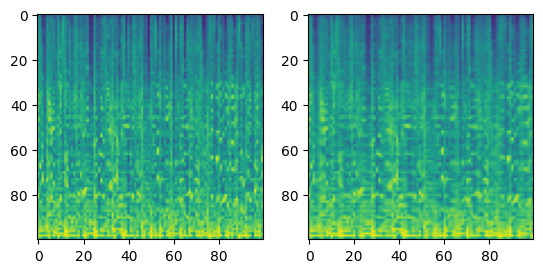

In [12]:
stretch_percentages = [1, 0.9 , 0.8, 0.7]
x_train = np.zeros((x_train_simple.shape[0] * len(stretch_percentages), x_train_simple.shape[1], x_train_simple.shape[2]))
y_train = np.repeat(y_train_simple, repeats=len(stretch_percentages), axis=0)
i = 0

for image in x_train_simple:
    for stretch in stretch_percentages:
        crop = image[:,:int(image.shape[0] * stretch)]
        
        streched = cv2.resize(crop, image.shape)
        x_train[i] = streched
        i += 1

print(x_train.shape)
del x_train_simple
del y_train_simple

n = 2
fig, axs = plt.subplots(1, n)
for i in range(n):
    axs[i].imshow(x_train[i])
plt.show()

In [13]:

def freq_mask_k_times(image_data, param=20, k=1):
    augmented_data = image_data
    for i in range(k):
        augmented_data = tfio.audio.freq_mask(augmented_data, param=param)
    return augmented_data

def time_mask_k_times(image_data, param=20, k=1):
    augmented_data = image_data
    for i in range(k):
        augmented_data = tfio.audio.time_mask(augmented_data, param=param)
    return augmented_data

print(x_train.shape, y_train.shape)
x_train, y_train = augmented(x_train, y_train, f=freq_mask_k_times, n=1)
print("after freq mask", x_train.shape, y_train.shape)
x_train, y_train = augmented(x_train, y_train, f=time_mask_k_times, n=2)
print("after time mask", x_train.shape, y_train.shape)

def warp_image(image_data, W=10):

    # Reshape to [Batch_size, time, freq, 1] for sparse_image_warp func.
    mel_spectrogram = np.reshape(image_data, (-1, image_data.shape[0], image_data.shape[1], 1))
    v, tau = mel_spectrogram.shape[1], mel_spectrogram.shape[2]
    horiz_line_thru_ctr = mel_spectrogram[0][v//2]
    random_pt = horiz_line_thru_ctr[(random.randrange(W, tau - W))] # random point along the horizontal/time axis
    w = np.random.uniform(-W, W) # distance

    # Source Points
    src_points = [[[v//2, random_pt[0]]]]
    
    # Destination Points
    dest_points = [[[v//2, random_pt[0] + w]]]
    mel_spectrogram = mel_spectrogram.astype('float32')
    mel_spectrogram, flowfield = tfa.image.sparse_image_warp(mel_spectrogram, src_points, dest_points, num_boundary_points=2)
    mel_spectrogram = np.squeeze(mel_spectrogram)
    return mel_spectrogram

(2664, 100, 100) (2664, 10)


100%|██████████| 2664/2664 [00:09<00:00, 288.80it/s]


after freq mask (5328, 100, 100) (5328, 10)


100%|██████████| 5328/5328 [00:28<00:00, 187.83it/s]


after time mask (15984, 100, 100) (15984, 10)


### Describing the model

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
import random

num_classes = use_n_genres
inputs = Input(shape=(input_shape + (1,)))

# lamda is the weight of the L2 penalty term
lamda = 0.01                  
L2_regularizer = keras.regularizers.l2(lamda)
initializer = tf.keras.initializers.HeNormal(seed=random.randint(0,1000))

# ********************************************* Model ********************************************
# Encoder (convolutional base)
x = Conv2D(16, kernel_size=(3,3), kernel_regularizer=L2_regularizer,  kernel_initializer=initializer)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3,3),kernel_regularizer=L2_regularizer, kernel_initializer=initializer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, kernel_size=(3,3),kernel_regularizer=L2_regularizer, kernel_initializer=initializer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, kernel_size=(3,3),kernel_regularizer=L2_regularizer, kernel_initializer=initializer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(32,kernel_regularizer=L2_regularizer)(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()
# ********************************************* Model ********************************************

# Best val_acc = 73%, best test_acc = 72%

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 98, 98, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 32)        4640  

In [5]:
# Run this if you want to load the pretrained model
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('./Model/')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 98, 98, 16)        160       
                                                                 
 batch_normalization_10 (Bat  (None, 98, 98, 16)       64        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 98, 98, 16)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 49, 49, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 32)        4640

### Dynamic Learning Rate Scheduler

In [6]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.losses.append(current)
        if len(self.losses) < 5: # We only consider learning rate decrease after 5 epochs since the last decrease.
            print(" lr: {:.6f}".format(lr) )
            return
        if len(self.losses) > 5:
            self.losses.pop(0)
        scheduled_lr = self.schedule(lr,self.losses)
        if lr != scheduled_lr:
            self.losses = [] # We empty the loss array after we decreased the learning rate.
        tf.keras.backend.set_value(self.model.optimizer.lr, 
        scheduled_lr)
        print(" lr: {:.6f}".format(scheduled_lr) )      

def lr_schedule(lr, losses):
    mean = sum(losses[:len(losses)-1]) / len(losses[:len(losses)-1])
    last_loss = losses[-1]
    if last_loss >= mean*0.9: # If there is not at least 10% improvent regarding the mean of the previous losses, then we decrease.
        lr = lr/2
    return lr

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12,restore_best_weights=True)

### Compile and Run The Code

In [7]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.02, nesterov=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=60,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[CustomLearningRateScheduler(lr_schedule),early_stopping_callback])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7790635824203491
Test accuracy: 0.5833333134651184


### Evaluation

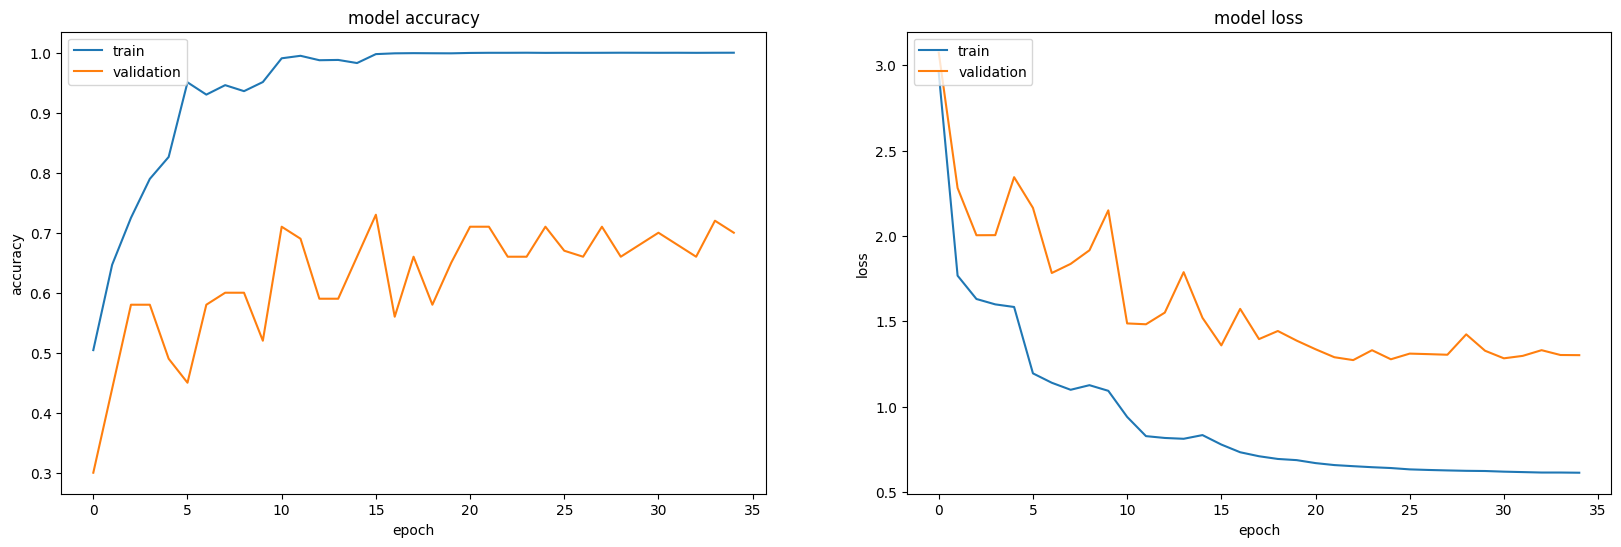

In [57]:
def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

(3, 3, 1, 16)


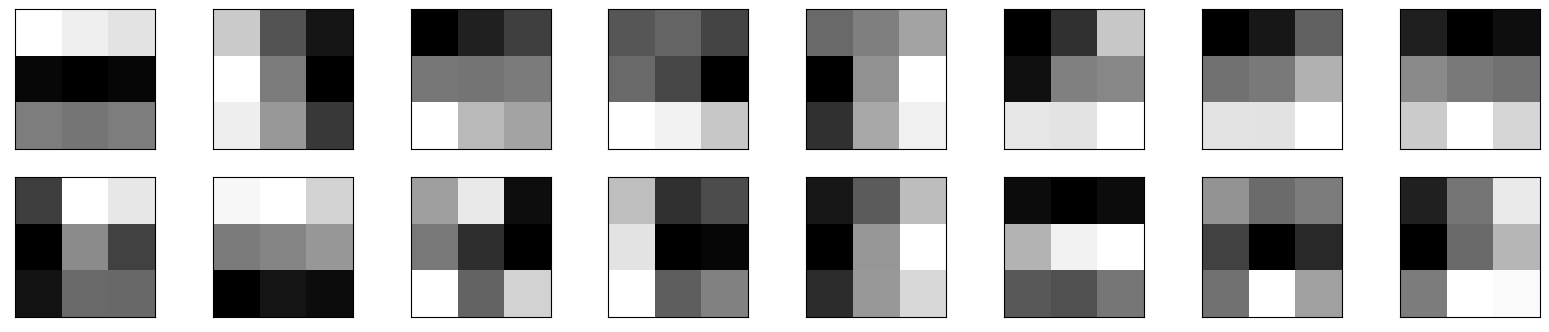

In [58]:
# Displaying the first filters
W = np.asarray(model.layers[1].get_weights()[0])
n_filters = W.shape[3]
print(W.shape)
W = W.reshape((*W.shape[:2], n_filters))
plt.figure(figsize=(20,4))
for i in range(n_filters):
  ax = plt.subplot(2, (n_filters + 1) // 2, i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

In [70]:
predictions = model.predict(x_test)

def top1_error(preds,labels):
    return np.mean(np.argmax(preds,axis=1) != np.argmax(labels,axis=1))

print("Top-1 error is: " + str(top1_error(predictions,y_test[:len(predictions)])))

def top_n_error(preds,labels, n=5):

    wrongs = 0
    for prediction, label in zip(preds, labels):
        top_n = np.flip(np.argsort(prediction))[:n]
        correct = np.argmax(label)

        if correct not in top_n:
            wrongs += 1
    return wrongs / len(preds)

print("Top-5 error is: " + str(top_n_error(predictions,y_test[:len(predictions)], 5)))

4/4 [==============================] - 0s 45ms/step
Top-1 error is: 0.32
Top-5 error is: 0.05


2/3 [===================>..........] - ETA: 0s

2022-12-06 13:10:32.998618: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19668992 exceeds 10% of free system memory.
2022-12-06 13:10:33.045769: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19668992 exceeds 10% of free system memory.
2022-12-06 13:10:33.091227: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19668992 exceeds 10% of free system memory.
2022-12-06 13:10:33.111241: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19668992 exceeds 10% of free system memory.
2022-12-06 13:10:33.149022: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19668992 exceeds 10% of free system memory.


3/3 [==============================] - 0s 59ms/step
[6 9 1 1 1 3 4 9 8 6 7 2 0 8 2 2 6 1 2 1 4 6 3 9 4 4 9 9 5 1 1 6 9 9 9 6 5
 6 9 6 0 0 6 8 9 9 7 9 3 1 2 9 7 7 7 6 5 0 4 2 0 8 7 5 6 7 6 1 9 4 1 1 3 3
 4 7 6 1 3 5 1 7 0 4 5 5 3 0 3 9 6 5 5 4 0 8]
[6 9 2 1 1 0 4 2 8 9 3 2 0 8 2 2 6 1 2 1 4 6 3 9 4 4 9 3 5 1 0 6 9 0 0 6 5
 0 2 6 0 0 6 8 9 9 2 3 3 1 0 9 7 7 7 6 5 0 4 2 0 8 7 5 2 7 6 5 9 4 1 1 3 3
 4 7 6 1 3 5 2 9 7 4 5 5 3 0 3 9 9 5 5 3 0 8]


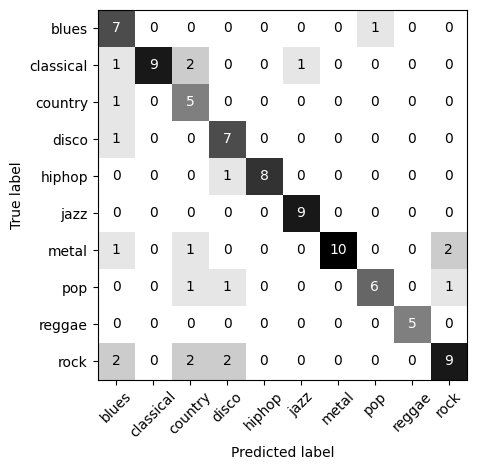

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

labels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
predictions = model.predict(x_test)
pred_classes = np.argmax(predictions, axis=1)
print(pred_classes)
test_classes = np.argmax(y_test, axis=1)
print(test_classes)
cm = confusion_matrix(pred_classes, test_classes)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(ax=ax, cmap="binary", colorbar=False)
ax.set_xticklabels(labels, rotation = 45)
plt.savefig("confusion.png",  bbox_inches='tight')
plt.show()

3/3 [==============================] - 0s 46ms/step


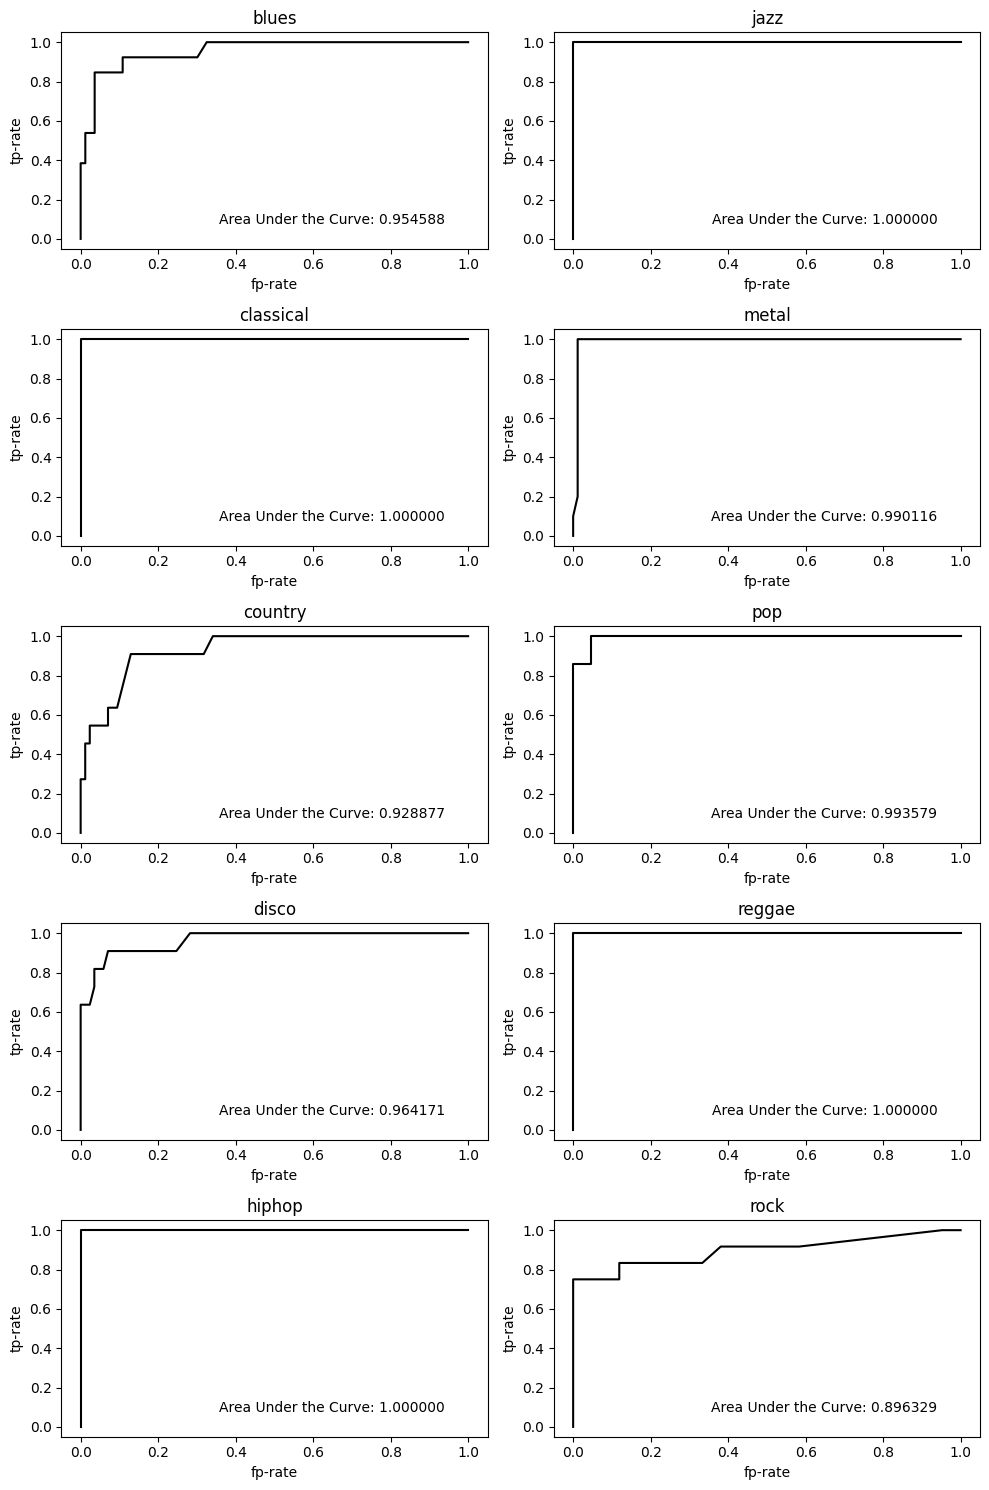

In [19]:

def confusion_matrix(predictions, r, theta):
    """computes a confusion matrix with theta as the threshold"""
    confusion = np.zeros((2, 2))

    for i in range(len(r)):
        y = predictions[i]
        if y >= theta and r[i] == 1:
            confusion[0, 0] += 1
        elif y < theta and r[i] == 1:
            confusion[0, 1] += 1
        elif y > theta and r[i] == 0:
            confusion[1, 0] += 1
        else:
            confusion[1, 1] += 1
    return confusion


def performance_measure(X, r, theta, return_val):
    """returns either tp-rate, accuracy or fp-rate,
    based on the return_val argument"""
    confusion = confusion_matrix(X, r, theta)
    tp = confusion[0, 0]
    fn = confusion[0, 1]
    fp = confusion[1, 0]
    tn = confusion[1, 1]
    p = tp + fn
    n = fp + tn
    if return_val == "tp":
        return tp / p
    elif return_val == "acc":
        return (tn + tp) / (n + p)
    elif return_val == "fp":
        return fp / n
    else:
        raise ValueError("Invalid performance measure")


def plot_roc(predictions, test_y, class_, ax):
    """Plots the ROC curve on the test data"""

    r = test_y[:,class_] > 0.5
    X = predictions[:,class_]

    N = predictions.shape[0]
    confusion = confusion_matrix(X, r, 0.5)
    accuracy = (confusion[0, 0] + confusion[1, 1]) / N

    theta = np.linspace(1, 0, 200)
    x = [performance_measure(X, r, i, "fp") for i in theta]
    y = [performance_measure(X, r, i, "tp") for i in theta]

    ax.plot(x, y, "-", label="ROC", color="black")
    ax.set_xlabel("fp-rate")
    ax.set_ylabel("tp-rate")
    ax.set_title(labels[i])

    AUC = np.trapz(y, x)
    ax.text(
        0.9,
        0.1,
        f"Area Under the Curve: {AUC:.6f}",
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax.transAxes,
    )

fig, axs = plt.subplots(5, 2, figsize=(10, 15))

predictions = model.predict(x_test)
for i in range(10):

    plot_roc(predictions, y_test, i, axs[i%5][i//5])
fig.tight_layout()
plt.savefig("OvR-AUC.png")
plt.show()


In [58]:
from collections import Counter
pred_counter = Counter(np.argmax(predictions, axis=1))
true_counter = Counter(np.argmax(y_test, axis=1))
print(pred_counter)
print(true_counter)

from help import label_to_genre
def showRandomPredictions(preds,labels):
    maxInd = len(preds)
    print("--------------------------")
    for i in range(5):
        randInd = random.randint(0,maxInd-1)
        onehot = np.zeros(use_n_genres)
        onehot[np.argmax(preds[randInd])] = 1
        print("Prediction: \t" + str(label_to_genre(list(onehot))))
        print("Label:\t\t" + str(label_to_genre(list(labels[randInd]))))
        print("--------------------------")

showRandomPredictions(predictions,y_test)

Counter({4: 16, 7: 14, 6: 12, 9: 11, 1: 9, 5: 9, 0: 9, 2: 8, 3: 5, 8: 3})
Counter({3: 14, 2: 13, 7: 12, 0: 12, 9: 11, 5: 9, 1: 8, 8: 7, 4: 6, 6: 4})
--------------------------
country
Prediction: 	2
disco
Label:		3
--------------------------
metal
Prediction: 	6
disco
Label:		3
--------------------------
blues
Prediction: 	0
metal
Label:		6
--------------------------
classical
Prediction: 	1
rock
Label:		9
--------------------------
pop
Prediction: 	7
classical
Label:		1
--------------------------


Weights:

<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.core.dense.Dense'>


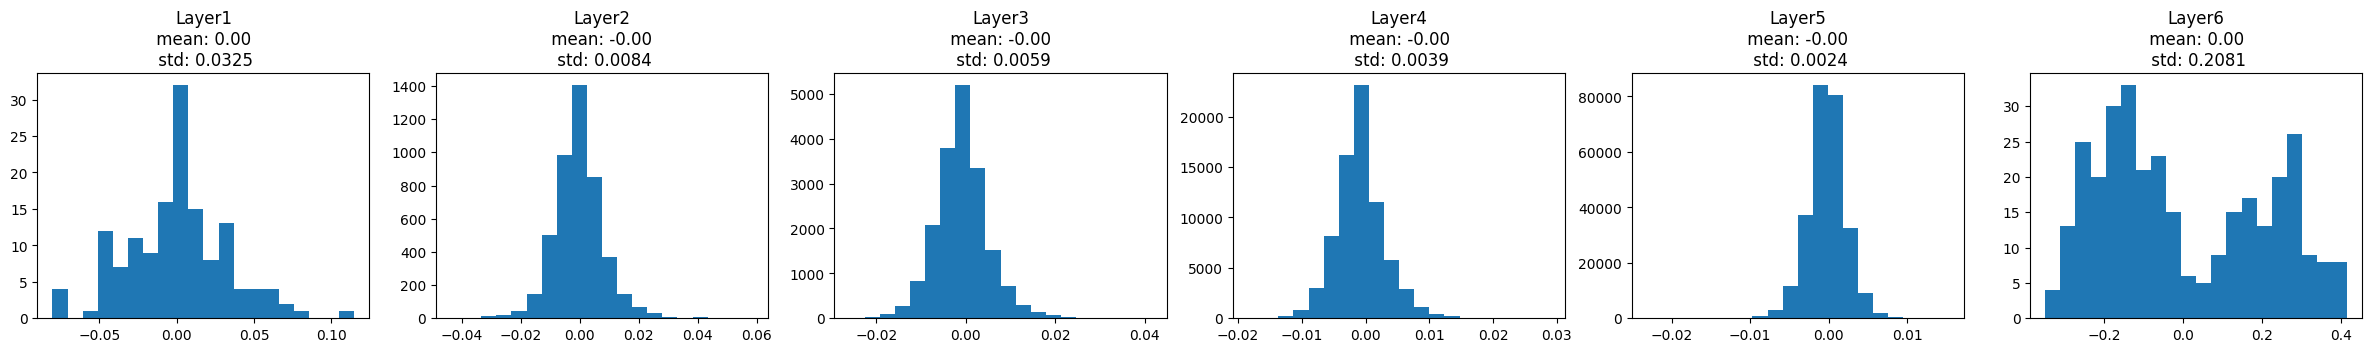

In [61]:
def ShowWeightStats(model):
    print('Weights:\n')
    plt.figure(figsize=(30,7))
    numOfWeightedLayers = 0
    for layer in model.layers:
        if len(layer.get_weights()) != 0 and type(layer) != BatchNormalization:
            numOfWeightedLayers = numOfWeightedLayers+1
    i = 1
    for layer in model.layers:
        if len(layer.get_weights()) != 0 and type(layer) != BatchNormalization:
            w = np.asarray(layer.get_weights()[0]).flatten()
            mean = w.mean()
            std = np.std(w)
            plt.subplot(2,numOfWeightedLayers,i)
            plt.title("Layer" + str(i) + f"\n mean: {mean:.2f} \n std: {std:.4f}")
            plt.hist(w,bins=20)
            i = i + 1
    plt.show()
ShowWeightStats(model)

### Save the model

In [56]:
# The job is done.
model.save('./Model')

INFO:tensorflow:Assets written to: ./Model\assets


INFO:tensorflow:Assets written to: ./Model\assets
